# Практическая работа 5. Разведочный анализ данных с помощью PySpark

# **1. Инициализация платформы Spark и загрузка данных в фрейм данных Spark** <a class="anchor" id="1"></a>


Источник данных: https://www.kaggle.com/datasets/dhruvildave/spotify-charts

In [1]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
ls

advanced_pyspark_for_exploratory_data_analysis.ipynb
data/
docker-compose.yml
images/
pyspark2024/
pyspark-for-data-science.ipynb
pySpark_tutorial-master/
README.md


In [3]:
cd data

/home/user/work/data


In [4]:
ls

charts.csv  endomondoHR.json  movie_ratings_df.csv


In [5]:
! pip install pyspark

In [6]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'charts.csv' # Загрузите данные в текущий каталог Colab.
# filename_data = 'data/endomondoHR.json' # Загрузите данные в каталог data/  при работе в Docker.
# Загрузите основной набор данных в фрейм данных pyspark.
df = spark.read.csv(filename_data, mode="DROPMALFORMED", header=True, inferSchema=True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [7]:
df.show()

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

# **2. Обзор набора данных** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

### Схема, столбцы и типы данных набора:
   *Набор данных содержит как столбцы с одним значением (int, string), так и столбцы, состоящие из списка массивов.*

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_date

df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
df = df.withColumn("rank", col("rank").cast(IntegerType()))
df = df.withColumn("streams", col("streams").cast(IntegerType()))


In [9]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: integer (nullable = true)

Обзор столбцов


,Column Name,Data type
0,title,string
1,rank,int
2,date,date
3,artist,string
4,url,string
5,region,string
6,chart,string
7,trend,string
8,streams,int


In [10]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()

print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(2).toPandas()

Описание фрейма данных (только строковые и числовые столбцы):


,summary,title,rank,artist,url,region,chart,trend,streams
0,count,26173514,26171372,26173514,26173514,26173514,26173514,26173514,20318183
1,mean,Infinity,80.92462917114166,1987.9348473218754,6.642857142857143,None,None,None,55266.54339716303
2,stddev,NaN,59.18592706939082,15032.62146489825,9.888665950759702,None,None,None,209602.0198801989
3,min,!,1,"K. 265""",4,2nyce,"Albert06 El Veterano""",Balbi El Chamaco,1001
4,max,🪐,200,"Ｍ, 兩千 2ØØØ, RedcolorG",朱哲伟,https://open.spotify.com/track/7yNZNz5AslLutGc...,viral50,viral50,19749704


Общее количество 26173514 строк, печатаем несколько первых строк:


,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988


# **3. Обнаружение пропущенных значений и аномальных нулей.** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)

После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.
– Для строковых столбцов  проверяем наличие `None` и `null`.
- Для числовых столбцов проверяем наличие нулей и `NaN`.
- Для столбцов типа массив проверяем, содержит ли массив нули или `NaN`.


In [11]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,title,string
1,rank,int
2,date,date
3,artist,string
4,url,string
5,region,string
6,chart,string
7,trend,string
8,streams,int


In [12]:
string_columns = ['title', 'artist', 'url', 'region', 'chart', 'trend']
numeric_columns = ['rank','streams']
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,title,rank,artist,url,region,chart,trend,streams
0,0,0,0,0,0,0,0,0


# **4. Ленивая оценка Pyspark** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)

Здесь мы начнем знакомиться с некоторыми функциями продвинутого `Spark`: **Ленивая оценка**.

<font color="red"><b>Ленивая оценка</b></font> расширяет возможности Apache Spark за счет сокращения времени выполнения операций RDD. Он поддерживает граф происхождения для запоминания операций над RDD. мы можем просто помнить, что вся обработка в Pyspark — это абстракция. Когда мы хотим вернуть результаты, мы на самом деле сообщаем Spark, какой конечный ответ вас интересует, и он определяет лучший способ получить его. В результате это оптимизирует производительность и обеспечивает отказоустойчивость.

Чтобы увидеть результат, нам нужно вызвать `Spark.collect()`.

Обычно можем показать результаты с помощью синтаксиса: `df.take(k)` или `df.limit(k)`, чтобы получить результаты с `k`-строкой.

Когда `K` становится большим числом, выполнение этих двух способов, описанных выше, занимает много времени. Потому что приведенный выше синтаксис не использовал возможности обработки `Pyspark` (ленивая оценка).
Чтобы быстро обработать, требуется использовать `df.collect()[:k]` для возврата строки `k`, которая нам требуется.

Подробнее о ленивых вычислениях `Pyspark` можно прочитать в статье : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [13]:
from pyspark.sql.functions import count

# Преобразуем "streams" в миллионы
df_transformed = df.withColumn("streams_millions", col("streams") / 1000000)

# Фильтруем по чарту
df_filtered = df_transformed.filter(col("chart") == "top200")

# Группируем по региону
df_grouped = df_filtered.groupBy("region").agg(count("title").alias("total_songs"))  

In [14]:
df_grouped.collect()[:5]

[Row(region='Paraguay', total_songs=336666),
 Row(region='Sweden', total_songs=358384),
 Row(region='Philippines', total_songs=358390),
 Row(region='Malaysia', total_songs=358390),
 Row(region='Singapore', total_songs=358388)]

In [15]:
from pyspark.sql.functions import sum

# Фильтруем артистов по количеству прослушиваний
artisits_by_streams = df_transformed.groupBy("artist") \
                                          .agg(sum("streams").alias("total_streams")) \
                                          .orderBy("total_streams", ascending=False)

# Выделение топ 20 артистов по прослушиваням
top_20_artisits_by_streams = artisits_by_streams.limit(20).toPandas()

# Для далнейшего вычисления процента
total_artisits_by_streams = artisits_by_streams.groupBy().sum().collect()[0][0]

In [16]:
artisits_by_streams.collect()[:20]

[Row(artist='Ed Sheeran', total_streams=23595661934),
 Row(artist='Post Malone', total_streams=19452753354),
 Row(artist='Drake', total_streams=18180639343),
 Row(artist='Billie Eilish', total_streams=17193796480),
 Row(artist='Ariana Grande', total_streams=15375848331),
 Row(artist='Dua Lipa', total_streams=12147106434),
 Row(artist='Juice WRLD', total_streams=12133081886),
 Row(artist='XXXTENTACION', total_streams=12071900406),
 Row(artist='The Weeknd', total_streams=12042803794),
 Row(artist='Olivia Rodrigo', total_streams=9517652325),
 Row(artist='Travis Scott', total_streams=9291822703),
 Row(artist='Justin Bieber', total_streams=9239499887),
 Row(artist='Bad Bunny', total_streams=8859643251),
 Row(artist='Taylor Swift', total_streams=8054414076),
 Row(artist='Lil Nas X', total_streams=7668590857),
 Row(artist='Imagine Dragons', total_streams=7571080671),
 Row(artist='Doja Cat', total_streams=7225519186),
 Row(artist='Harry Styles', total_streams=7083410703),
 Row(artist='Lewis Ca

# **5. Исследовательский анализ данных** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)

Давайте сначала составим таблицу, указав 5 лучших типов тренировок, которые мы оценили выше.

In [17]:
artisits_by_streams_df_renamed = top_20_artisits_by_streams
# Вычислите процент пяти самых популярных типов тренировок от общего числа пользователей
artisits_by_streams_df_renamed['percentage'] = artisits_by_streams_df_renamed['total_streams'] \
    / total_artisits_by_streams * 100

# Мы относим остальных пользователей к другой конкретной группе, которую мы назовем 'others'
others = {
      'artist': 'others'
    , 'total_streams': total_artisits_by_streams - artisits_by_streams_df_renamed['total_streams'].sum()
    , 'percentage': 100 - artisits_by_streams_df_renamed['percentage'].sum()
}

df_others = pd.DataFrame([others])

artisits_by_streams_df_renamed = pd.concat([artisits_by_streams_df_renamed,df_others], ignore_index=True
)
print('Топ-20 артистов по прослушиваням:')
artisits_by_streams_df_renamed

Топ-20 артистов по прослушиваням:


,artist,total_streams,percentage
0,Ed Sheeran,23595661934,2.101285
1,Post Malone,19452753354,1.732343
2,Drake,18180639343,1.619056
3,Billie Eilish,17193796480,1.531174
4,Ariana Grande,15375848331,1.369279
5,Dua Lipa,12147106434,1.081747
6,Juice WRLD,12133081886,1.080498
7,XXXTENTACION,12071900406,1.075050
8,The Weeknd,12042803794,1.072458
9,Olivia Rodrigo,9517652325,0.847584


/tmp/ipykernel_108/2268239695.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(artisits_by_streams_df_renamed['artist']


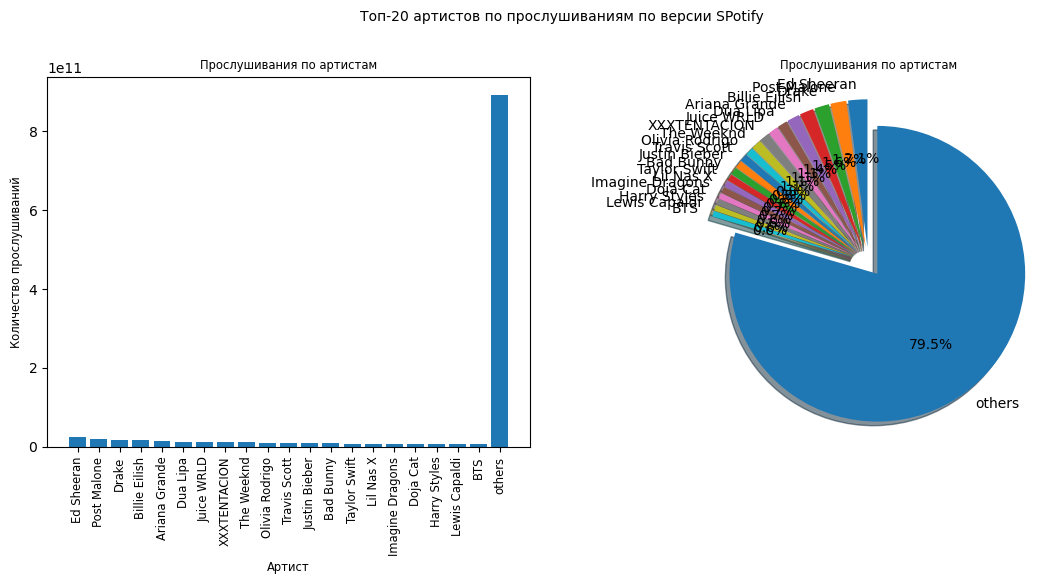

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=artisits_by_streams_df_renamed['artist']
                     , height=artisits_by_streams_df_renamed['total_streams'])
title0 =  axs[0].set_title('Прослушивания по артистам', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Артист', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Количество прослушиваний', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(artisits_by_streams_df_renamed['artist']
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
title1 = axs[1].set_title('Прослушивания по артистам', fontsize = 'small')
plot1 = axs[1].pie(
      x=artisits_by_streams_df_renamed['percentage']
    , labels=artisits_by_streams_df_renamed['artist']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Топ-20 артистов по прослушиваниям по версии SPotify', ha='center', va='top', transform=fig.transFigure)

Данные показывают, что ˜20% всех прослушиваний приходятся на 20 артистов

In [19]:
# Просмотр данных по виду артисту и региону
regions_by_artist = df.groupBy('region', 'artist').count().toPandas()
regions_by_artist[:5]

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


ConnectionRefusedError: [Errno 111] Connection refused

# **7. Pyspark UDF** <a class="anchor" id="6"></a>
[Go back to table of contents](#0.1)

Что такое `UDF`?

`User Defined Functions` - это пользовательские функции. Если  знакомы с `SQL`, `UDF` не являются для вас чем-то новым, поскольку большинство традиционных баз данных РСУБД поддерживают пользовательские функции, эти функции необходимо зарегистрировать в библиотеке базы данных и использовать их в `SQL` как обычные функции.

`UDF PySpark` аналогичны `UDF` в традиционных базах данных. В `PySpark` создается функция в синтаксисе `Python` и обертываете ее `PySpark SQL udf()` или регистрируете ее как `udf` и используете ее в `DataFrame` и `SQL` соответственно.

Зачем нужна `UDF`?

`UDF` используются для расширения функций платформы и повторного использования этих функций в нескольких `DataFrame`. Например, требуется преобразовать каждую первую букву слова в строке имени в заглавную; Встроенные функции `PySpark` не имеют этой функции, поэтому можно создать `UDF` и повторно использовать ее по мере необходимости во многих кадрах данных. После создания `UDF` их можно повторно использовать в нескольких выражениях `DataFrame` и `SQL`.

Прежде чем создавать какую-либо пользовательскую функцию, изучите, доступна ли аналогичная функция, которая вам нужна, в `Spark SQL Functions` . `PySpark SQL` предоставляет несколько предопределенных общих функций, и с каждым выпуском добавляется множество новых функций, следовательно, лучше всего проверить, прежде чем изобретать велосипед.

При создании `UDF`  необходимо проектировать их очень тщательно, иначе столкнетесь с проблемами оптимизации и производительности.

Короче говоря, регистрация UDF в Pyspark — это процесс **превращения функций Python в функции PySpark (UDF)**.

![Spark_vs_Pandas.jpg](https://drive.google.com/uc?export=view&id=1x5s0p9oa-dNIsNo5XzYQjdMQUxt99WYP)

Когда запускаем код в кластерах `Spark`, этот метод ускорит процесс и сэкономит время выполнения.

Чтобы узнать больше о `Pyspark UDF`, посетите https://changhsinlee.com/pyspark-udf/.

Выполним регистрацию функции Python к UDF в столбце `timestamp`.


Этот столбец очень важен, если используем этот набор данных для прогнозирования, например, для прогнозирования частоты пульса, чтобы определить возможные проблемы с сердцем у пользователя фитнес-трекера.


In [ ]:
# 1. Пример UDF: Получение имени исполнителя в верхнем регистре
def uppercase_artist(name):
    return name.upper()

# Создаем UDF и указываем тип возвращаемого значения
uppercase_udf = udf(uppercase_artist, StringType())

# Применяем UDF к столбцу "artist"
df = df.withColumn("artist_uppercase", uppercase_udf("artist"))

df.show()

# 2. Пример UDF: Получение длины названия песни
def title_length(title):
    return len(title)

# Создаем UDF и указываем тип возвращаемого значения
title_length_udf = udf(title_length, IntegerType())

# Применяем UDF к столбцу "title"
df = df.withColumn("title_length", title_length_udf("title"))

df.show()

# 3. Пример UDF: Преобразование количества стримов в миллионы
def to_millions(streams):
    return streams / 1_000_000.0

# Создаем UDF и указываем тип возвращаемого значения
to_millions_udf = udf(to_millions, DoubleType())

# Применяем UDF к столбцу "streams"
df = df.withColumn("streams_millions", to_millions_udf("streams"))

df.show()